# Part 1: Data Preparation and Exploration

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Load the dataset and parse dates
exchange_df = pd.read_csv("D:\Excelr\Assignments\Timeseries\exchange_rate.csv", parse_dates=['date'])

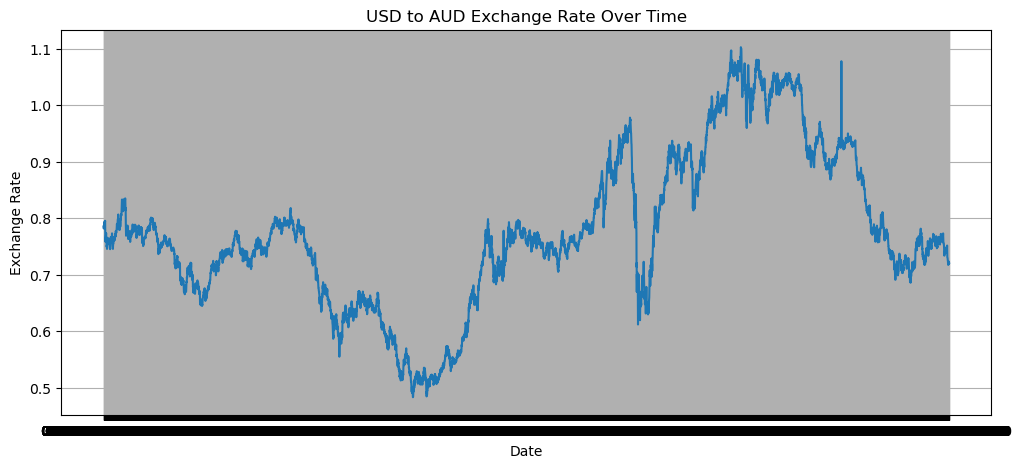

In [49]:
# Initial Exploration
plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='Ex_rate', data=exchange_df)
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.show()

In [50]:
# Check and handle missing values
print("Missing Values:\n", exchange_df.isnull().sum())

Missing Values:
 date       0
Ex_rate    0
dtype: int64


In [51]:
# Set date as index
exchange_df.set_index('date', inplace=True)

# Part 2: Model Building - ARIMA

In [53]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [54]:
# ADF Test
adf_result = adfuller(exchange_df['Ex_rate'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -1.664994180738078
p-value: 0.44923273535982894


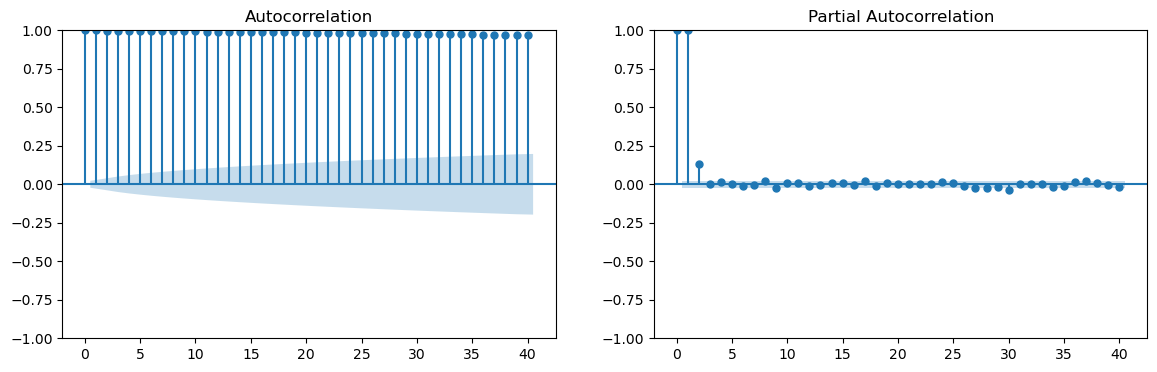

In [55]:
# ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(exchange_df['Ex_rate'], lags=40, ax=axes[0])
plot_pacf(exchange_df['Ex_rate'], lags=40, ax=axes[1])
plt.show()

In [56]:
# Fit ARIMA model (example: p=1, d=1, q=1)
arima_model = ARIMA(exchange_df['Ex_rate'], order=(1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 23 Apr 2025   AIC                         -56102.322
Time:                        02:05:54   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

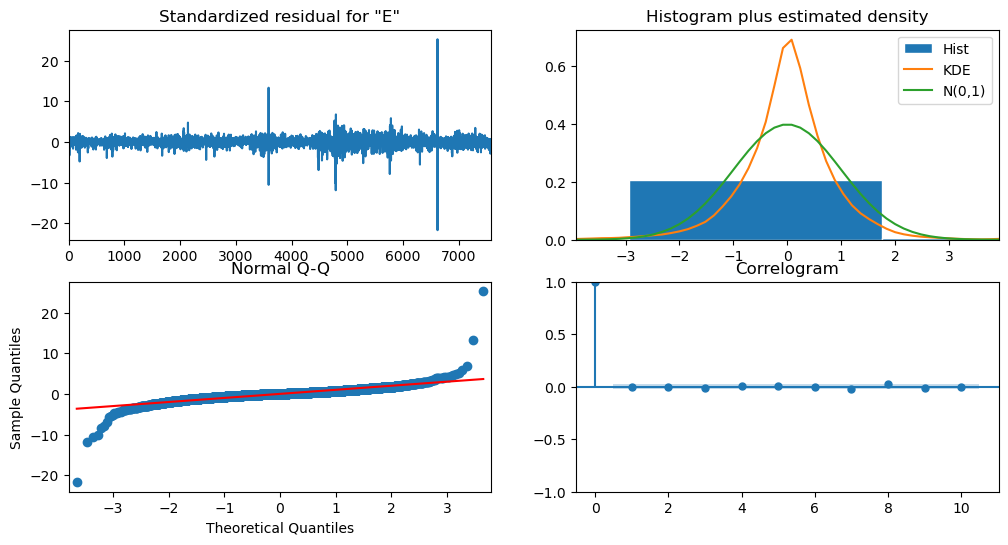

In [57]:
# Diagnostics
arima_result.plot_diagnostics(figsize=(12, 6))
plt.show()

In [58]:
# Forecast
forecast_arima = arima_result.get_forecast(steps=24)
forecast_df = forecast_arima.summary_frame()

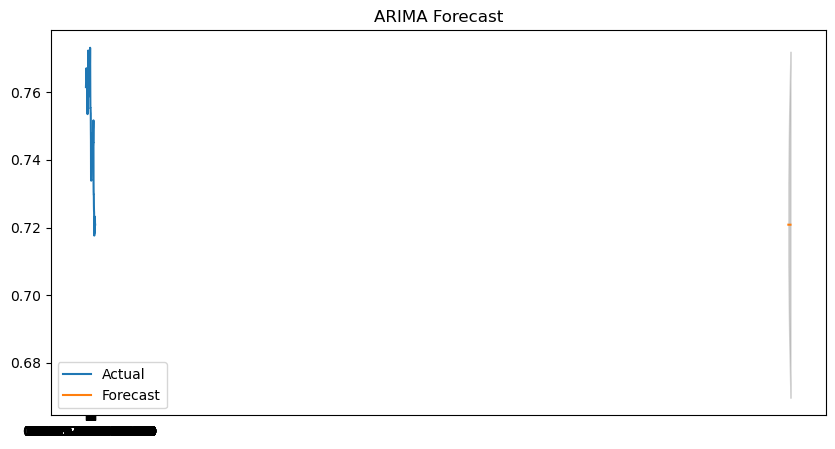

In [59]:
# Forecast plot
plt.figure(figsize=(10, 5))
plt.plot(exchange_df.index[-100:], exchange_df['Ex_rate'][-100:], label='Actual')
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='gray', alpha=0.3)
plt.title("ARIMA Forecast")
plt.legend()
plt.show()

# Part 3: Model Building - Exponential Smoothing

In [61]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [62]:
# Fit Holt-Winters (no seasonality)
hw_model = ExponentialSmoothing(exchange_df['Ex_rate'], trend='add', seasonal=None)
hw_fit = hw_model.fit()

In [63]:
# Forecast
forecast_hw = hw_fit.forecast(steps=24)

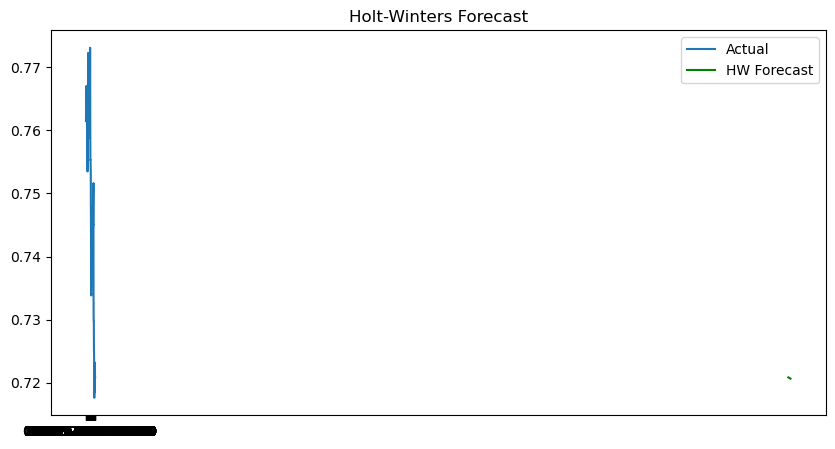

In [64]:
# Forecast plot
plt.figure(figsize=(10, 5))
plt.plot(exchange_df.index[-100:], exchange_df['Ex_rate'][-100:], label='Actual')
plt.plot(forecast_hw.index, forecast_hw, label='HW Forecast', color='green')
plt.title("Holt-Winters Forecast")
plt.legend()
plt.show()

# Part 4: Evaluation and Comparison

In [143]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [153]:
# Actual values for comparison
actual_values = exchange_df['Ex_rate'][-24:]

# Align predictions for evaluation
arima_forecast = forecast_df['mean'][:24]
hw_forecast = forecast_hw[:24]

In [155]:
# Compute metrics
def evaluate_forecast(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = evaluate_forecast(actual_values, arima_forecast)
hw_mae, hw_rmse, hw_mape = evaluate_forecast(actual_values, hw_forecast)

In [157]:
# Print results
print("ARIMA - MAE:", arima_mae, "RMSE:", arima_rmse, "MAPE:", arima_mape)
print("Holt-Winters - MAE:", hw_mae, "RMSE:", hw_rmse, "MAPE:", hw_mape)

ARIMA - MAE: 0.009594240194402448 RMSE: 0.014172119009541325 MAPE: nan
Holt-Winters - MAE: 0.009609224219947601 RMSE: 0.014176147993413973 MAPE: nan
